In [1]:
import pandas as pd
import scipy.stats
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class RandomIIDDemand :
    def __init__(self, nb_products, distributions: List[scipy.stats.rv_continuous]) :
        self.nb_products = nb_products
        self.distributions = distributions
    def get_next_demand(self):
        return [self.distributions[i].rvs() for i in range(nb_products)]

In [54]:
class AbstractInventoryPolicy() :
    def __init__(self) :
        pass
    def order_quantity(self,t,starting_state_vector) -> List[float] :
        return .0

class ConstantOrderQuantity(AbstractInventoryPolicy) :
    def __init__(self,constant_order_quantity : List[float]) :
        self.constant_order_quantity = constant_order_quantity
        print("Constant order quantiy: {}".format(self.constant_order_quantity))
    def order_quantity(self,t,starting_state_vector) -> List[float] :
        return self.constant_order_quantity

class OptimalUnconstrainedPolicy(AbstractInventoryPolicy) :
    """
    Optimal clairvoyant policy for the infinite-horizon lost sales problem with :
        * No volume constraints (the problem is separable per product)
        * Zero fixed cost
        * Zero lead time
        * Infinite life time
        * i.i.d demand
        * Discount factor (gamma) in [0,1]

    If q is the quantile function of the single period demand of a given product this policy is base-stock policy with target level q((p-c)/(h+p-gamma*c))
    
    See Paragraph 4.6.1 of (Fundamentals of Supply Chain Theory)
    """
    def __init__(self, nb_products, purchase_costs, holding_costs, stockout_costs, discount_factor : float, random_iid_demand : RandomIIDDemand) :
        self.nb_products = nb_products
        self.base_stock_levels = np.zeros(nb_products)
        for i in range(nb_products) : 
            if(holding_costs[i]+stockout_costs[i]-discount_factor*purchase_costs[i] == 0) :
                print("Costs for product {} leads to a degenerate solution: infinite target level.".format(i))
            if((stockout_costs[i]-purchase_costs[i])*(holding_costs[i]+stockout_costs[i]-discount_factor*purchase_costs[i]) <= 0) :
                print("The optimal unconstrainted strategy for product {} is never order.".format(i))
            self.base_stock_levels[i] = random_iid_demand.distributions[i].ppf((stockout_costs[i]-purchase_costs[i])/(holding_costs[i]+stockout_costs[i]-discount_factor*purchase_costs[i]))
        print("Optimal unconstrainted base-stock level: {}".format(self.base_stock_levels))

    def order_quantity(self,t,starting_state_vector) -> List[float] :
        quantities = np.zeros(self.nb_products)
        for i in range(self.nb_products) :
            quantities[i] = np.maximum(0,self.base_stock_levels[i] - np.sum(starting_state_vector[i]))
        #print("Starting from {}, ordering {}".format(np.sum(starting_state_vector[i]),quantities[i]))
        return quantities

class OptimalConstrainedPolicy(AbstractInventoryPolicy) :
    """
    Optimal clairvoyant policy for the multi-item volume-constrained lost sales problem with :
        * Zero fixed cost
        * Zero lead time

    See Theorem 1 of (Shi, C., Chen, W., & Duenyas, I. (2016). Nonparametric data-driven algorithms for multiproduct inventory systems with censored demand)
    or (Ignall, E., A. F. Veinott. 1969. Optimality of myopic inventory policies for several substitute products)
    """
    pass

In [4]:
def sell_old_first(extended_state_vector,demand) :
    sales_vector = [np.zeros(life_times[i]) for i in range(nb_products)]
    for i in range(nb_products) : 
        for j in range(life_times[i]) :
            sales_vector[i][j] = np.minimum(extended_state_vector[i][j], np.maximum(0,demand[i]-np.sum(sales_vector[i])))
    return sales_vector

In [56]:
seed = 0
np.random.seed(seed)

nb_products = 1
nb_periods = 100
unit_volumes = np.ones(nb_products)
life_times = nb_periods*np.ones(nb_products,dtype=int)
lead_times = np.zeros(nb_products,dtype=int)

fixed_costs = np.zeros(nb_products)
purchase_costs = np.random.lognormal(0,size=nb_products)
holding_costs = np.random.lognormal(0,size=nb_products)
stockout_costs = np.random.lognormal(2,size=nb_products)
outdating_costs = np.zeros(nb_products)
print("Costs:\n\tpurchase_costs: {}\n\tholding_costs: {}\n\tstockout_costs: {}".format(purchase_costs,holding_costs,stockout_costs))

demand_generator = RandomIIDDemand(nb_products,[scipy.stats.uniform(loc=0,scale=100) for i in range(nb_products)])

discount_factor = 1
policies = [
    OptimalUnconstrainedPolicy(nb_products, purchase_costs, holding_costs, stockout_costs, discount_factor, demand_generator),
    ConstantOrderQuantity([demand_generator.distributions[i].mean() for i in range(nb_products)]),
    ConstantOrderQuantity(np.zeros(nb_products))
]
policy_names = [
    "OptimalUnconstrained", 
    "MeanDemandOrderQuantity",
    "ZeroOrders"
]

for policy_id in range(len(policies)) : 
    policy = policies[policy_id]

    starting_state_vector = [np.zeros(lead_times[i]+life_times[i]-1) for i in range(nb_products)]
    history_ = pd.DataFrame(
        .0,
        index = pd.MultiIndex.from_product([np.arange(nb_periods),np.arange(nb_products)],names=["period","product_id"]),
        columns = ["fixed_cost","purchase_cost","holding_cost","stockout_cost","outdating_cost"]
    )

    for t in tqdm(range(nb_periods)) :
        q = np.array(policy.order_quantity(t,starting_state_vector))
        extended_state_vector = [np.append(starting_state_vector[i],q) for i in range(nb_products)]
        demand = demand_generator.get_next_demand()
        sales_vector = sell_old_first(extended_state_vector,demand)

        history_.loc[(t,slice(None)),"fixed_cost"] = np.where(q>0,fixed_costs,0)
        history_.loc[(t,slice(None)),"purchase_cost"] = purchase_costs*q
        history_.loc[(t,slice(None)),"holding_cost"] = holding_costs*np.maximum(0,np.sum([extended_state_vector[i][:life_times[i]]-demand[i] for i in range(nb_products)]))
        history_.loc[(t,slice(None)),"stockout_cost"] = stockout_costs*np.maximum(0,np.sum([demand[i]-extended_state_vector[i][:life_times[i]]  for i in range(nb_products)]))
        history_.loc[(t,slice(None)),"outdating_cost"] = outdating_costs*np.maximum(0,np.array([extended_state_vector[i][0] for i in range(nb_products)])-demand)

        starting_state_vector = [extended_state_vector[i][1:] - np.append(sales_vector[i][1:],np.zeros(lead_times[i])) for i in range(nb_products)]

    history_.to_csv("history_{}_".format(policy_id))

Costs:
	purchase_costs: [5.83603919]
	holding_costs: [1.49205924]
	stockout_costs: [19.66298598]
Optimal unconstrainted base-stock level: [90.26007797]
Constant order quantiy: [50.0]
Constant order quantiy: [0.]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Results

## Aggregated costs

In [57]:
for policy_id in range(len(policies)) :
    print("\nPolicy {}".format(policy_names[policy_id]))
    print(pd.read_csv("history_{}_".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum())
    print("Total cost: {:e}".format(pd.read_csv("history_{}_".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum().sum()))


Policy OptimalUnconstrained
purchase_cost    2.739996e+04
holding_cost     6.461410e+01
stockout_cost    9.165836e+06
dtype: float64
Total cost: 9.193301e+06

Policy MeanDemandOrderQuantity
purchase_cost    2.918020e+04
holding_cost     1.479183e+01
stockout_cost    9.909182e+06
dtype: float64
Total cost: 9.938377e+06

Policy ZeroOrders
purchase_cost    0.000000e+00
holding_cost     0.000000e+00
stockout_cost    1.012497e+07
dtype: float64
Total cost: 1.012497e+07


## Cumulative total cost

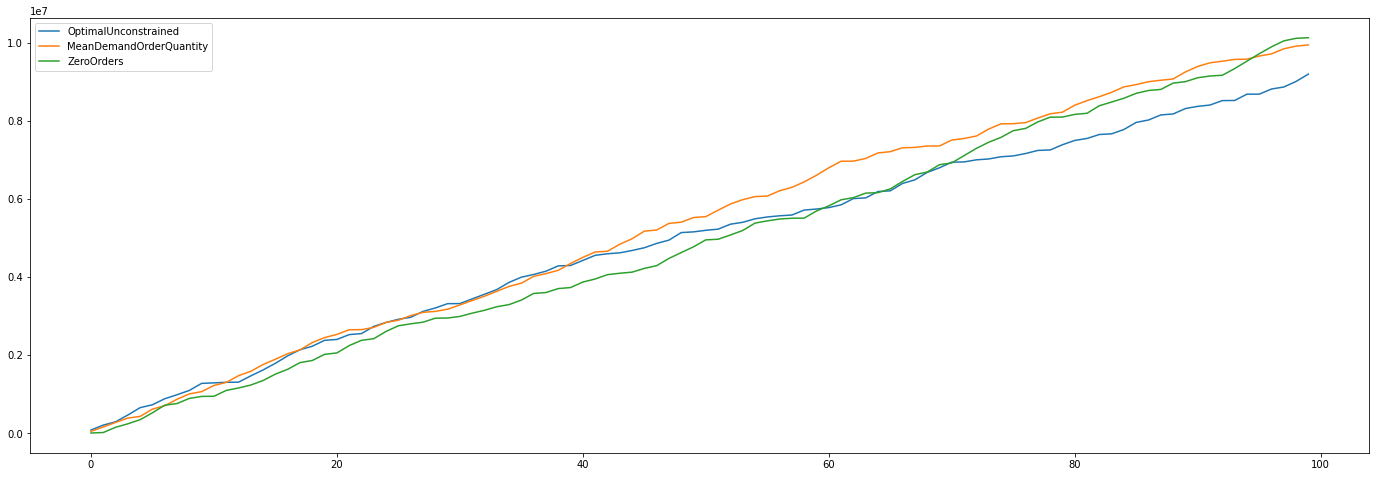

In [58]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("history_{}_".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

## Instantaneous holding cost

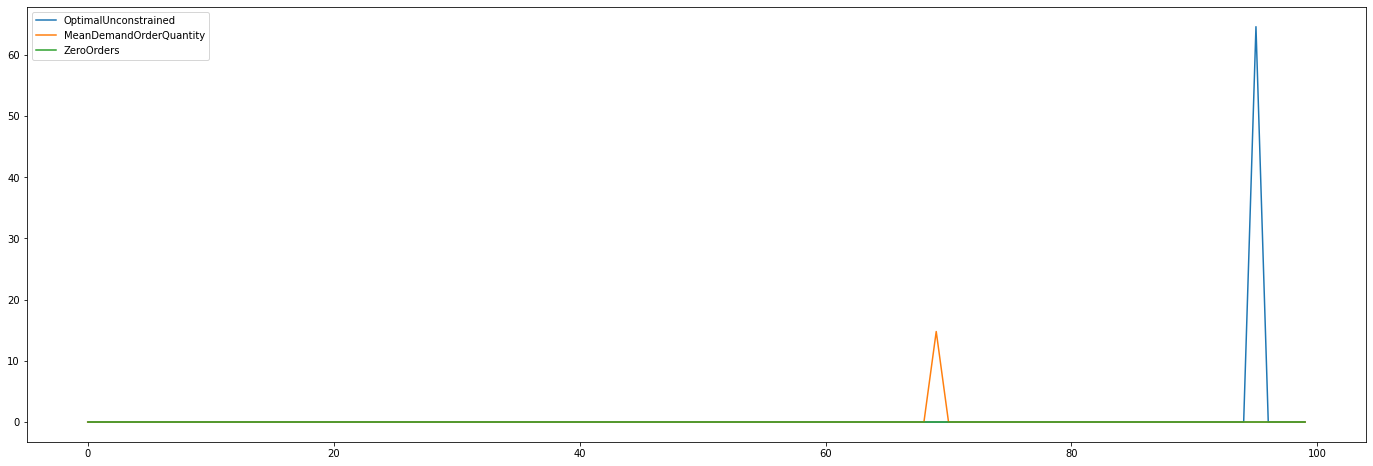

In [59]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("history_{}_".format(policy_id)).groupby("period").sum()["holding_cost"],label=policy_names[policy_id])
plt.legend()
plt.show()

## Cumulative stockout cost

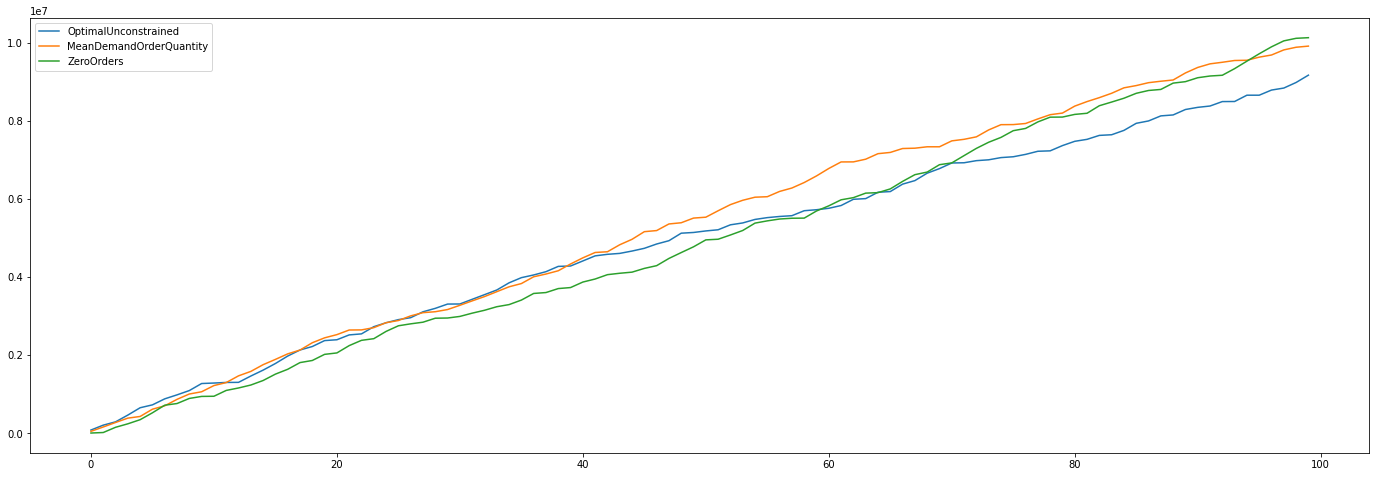

In [60]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("history_{}_".format(policy_id)).groupby("period").sum()["stockout_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

## Cumulative stockout cost

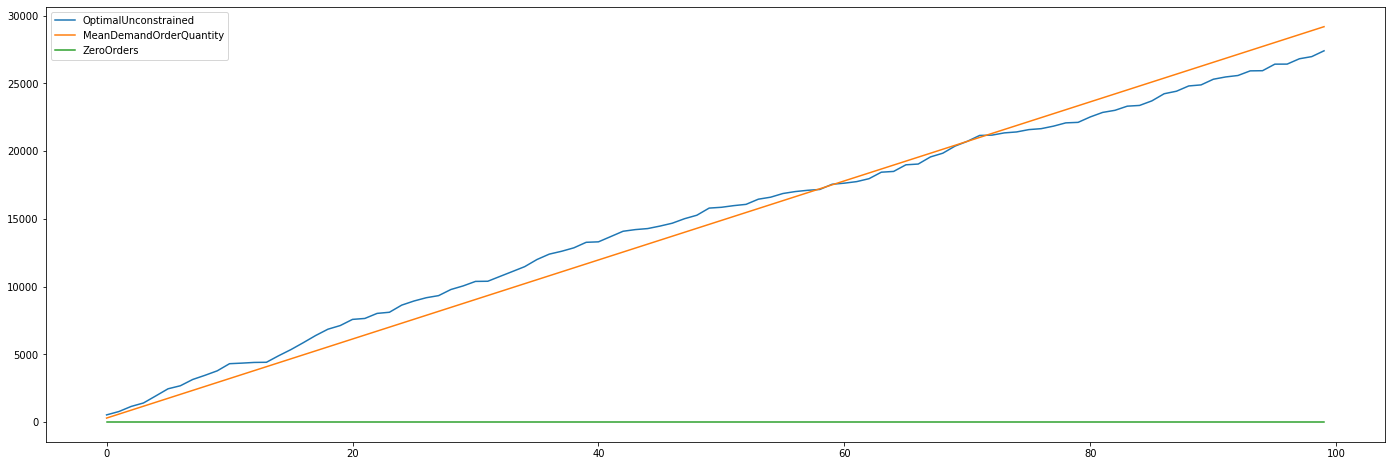

In [61]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("history_{}_".format(policy_id)).groupby("period").sum()["purchase_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()